In [28]:
import numpy as np
import pandas as pd
from ast import literal_eval
import seaborn as sns

from util.plotting import *

In [29]:
sns.set(rc={'figure.figsize': (20, 6)})
sns.set(font_scale=1.5)

In [30]:
# read df
converters = {"album_images": literal_eval, "hashtags": literal_eval, "comments_flat": literal_eval,
              "timestamp": pd.to_datetime, "image_label": literal_eval}
df = pd.read_csv("DepotBoijmans.csv", converters=converters, index_col="timestamp")
df

,shortcode,owner_username,MicroRole,MacroRole,likes,comment_count,location,owner_followercount,interactions,caption_en,hashtags,comment_en,num_images,image_label
timestamp,,,,,,,,,,,,,,
2020-01-01 14:34:39,postaf1cd604a7f645109218b27f109b3fea1b6720faee...,user8392bf148647eddd2fc3e3edf65add3268736213ed...,Individual,Private,27,2,NaN,93,29,#rotterdam#nederland#netherlands #holland#depo...,"[rotterdam, nederland, netherlands, holland, d...","['great photo henk, Happy new year to you and ...",1,[Outside]
2020-01-03 12:30:28,post3b75c80595d506a8d022c1751aa23c83faf0b8ebb9...,userc0337aa6f789320dd6040cefdd4261e0c8f98ed61c...,Individual,Private,11,0,Museum Boijmans Van Beuningen,176,11,#depotBoijmans #underconstruction #fascinating...,"[depotBoijmans, underconstruction, fascinating...",[],5,"[Outside, Outside, Outside, Outside]"
2020-01-03 14:53:16,post6a8292ba8694c8073b2fb6a4bad92a97afcdf023d7...,userf493e1a39259129fa2658ec2474b4e09689b2ba265...,Enterprise,Private,40,0,Westkop,960,40,Start the first weekend of the new year right ...,"[westkop, rotterdam, museumpark, bier, weekend...",[],1,[Misc]
2020-01-03 21:35:55,post7bfd20688f33426e1e5eaf767124178580f10b0182...,usereb1e6224cc3371fe9262695619be88cfa23095ea4e...,Individual,Private,9,1,NaN,43,10,#depot#museum#boijmans@user#january2020,"[depot, museum, boijmans, january2020]","['Wij waren ook in Rotterdam, hadden we nog ku...",1,[Misc]
2020-01-04 01:35:44,post8135f43902591b4a073e72b39531776c7cdf006b7d...,user59216ece376ad65994c9ccab8edb8b681c82e4ea41...,Individual,Private,309,6,Museum Boijmans Van Beuningen,4280,315,#Depot #boijmansvanbeuningen #museum #undercon...,"[Depot, boijmansvanbeuningen, museum, undercon...","['⚓️😍', '😃 @user', 'Nice fine contrast on this...",1,[Outside]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 16:02:27,post7c1c3c1db2129fe79a0226bbfe1356229e866a16d0...,userd6740396be33cad354155dda1a167b51ae1170d6f9...,Individual,Private,37,5,Rotterdam Centrum,190,42,Rotterdam's new ICON #skylinerotterdam #bearde...,"[depot, depotboijmansvanbeuningen, rotterdam, ...","['Mooi, wij moeten er binnenkort ook maar eens...",3,"[Outside, Outside]"
2021-12-31 18:47:37,post9d57b38dcb71de96f81340a67516acf4248f33ddf4...,user0982559bde8b51afab37ecbb54dc2c29a77cf56190...,Individual,Private,39,0,"Rotterdam, Netherlands",998,39,"Especially photos of the village where I live,...","[rotterdam, rottergram, rottergram010, rotterd...",[],1,[Misc]
2021-12-31 19:15:19,post464bb11a852053bb173d88a348cab76b7cbcd2e672...,user5bbe3e9245c38f2e8cc6e672213fedfdd5534c6968...,Individual,Private,14,0,Depot Boijmans van Beuningen,345,14,#batiment #architectural #musee #museum #build...,"[batiment, architectural, musee, museum, build...",[],1,[Outside]


# Dataset notes
The data was originally scraped from Instagram using a third-party scraper from rapidapi.com.
The dataset was pre-processed and cleaned in the following ways (not included in this notebook because they're manual or time-consuming):
- shortcode/owner_username: has been anonymized (hashed) for the publication of this dataset
- MicroRole/MacroRole: 107 'high-interaction' users were reviewed by two researchers (pre-anonymization) and categorized into 6 roles (see the paper for more details):
    - Public side: Affiliated Enterprise, Depot Boijmans Designer, Public Institution
    - Private side: Enterprise, Individual, Private Tourism Outlet
    All other users were classified as 'Individual'
- caption_en/comment_en: posts caption and comments was translated into English using https://pypi.org/project/deep-translator/ (not included in this notebook because it's time-consuming)
- image_label:  was set as the result of clustering+manual post-processing of clusters as well as labeling, see below in this notebook

# Pre-processing for the analysis

Split captions into the actual caption and trailing hashtags for being able to analyze the caption text and hashtags separately (there is some slight overlap in in-text hashtas like 'I went to the #depot yesterday but those are important for the meaning of the caption so they're left in)

In [31]:
def split_by_trailing_hashtags(text, punctuation_string=""):
    """
    Splits text into two parts:
    head: text including hashtags in the text
    tail: all trailing hashtags
    :param text:
    :param punctuation_string: characters in this string will be ignored when splitting
    e.g. "text .#bla #blub" will be split into "text" ".#bla #blub" (note the 'lost' space in the middle, have to add that when merging back)
    :return:
    """
    tail = []

    arr = text.split(" ")
    while len(arr) > 0:
        if arr[-1].startswith("#") or arr[-1].startswith("@") or arr[-1] in punctuation_string:
            tail = [arr[-1]] + tail
            arr = arr[:-1]
        else:
            break
    head = " ".join(arr)
    tail = " ".join(tail)

    return head, tail

df["caption_en"] = df["caption_en"].fillna("")
df["caption_en_head"] = df["caption_en"].apply(lambda x: split_by_trailing_hashtags(x)[0])

# Basic Data Overview by User and Actor Group

In [32]:
def format_bracket(val1, val2, percent=False, round_to=1, stdev=False):
    """
    Formats as 'val1 (val2)' or 'val1 (val2%)'
    """
    if round_to == 0:
        round_to = None
    if percent:
        str2 = " ({:.1%})"
    elif stdev:
        str2 = " (±{:,})"
        val2 = round(val2, round_to)
    else:
        str2 = " ({:,})"
        val2 = round(val2, round_to)

    return "{:,}".format(round(val1, round_to)) + str2.format(val2)

def elp_0(data):
    return format_bracket(np.mean(data), np.std(data), round_to=0, stdev=True)


def elp_1(data):
    return format_bracket(np.mean(data), np.std(data), round_to=1, stdev=True)


def elp_2(data):
    return format_bracket(np.mean(data), np.std(data), round_to=2, stdev=True)


def get_hashtag_counts_formatted(hashtag_list, top=5):
    flat = hashtag_list.explode()  # flatten series of lists into one long series
    ser = flat.value_counts()[:top]
    ser.name = "hashtags"
    ser = ser.reset_index()
    s = ""
    for idx, row in ser.iterrows():
        s += "{}({}) ".format(row["index"], row["hashtags"])
    return s


def meanround(data, round_to=1):
    if round_to == 0:
        round_to = None
    return round(np.mean(data), round_to)


df_summary = df.copy()
total_interactions = df_summary["interactions"].sum()
total_followers = df_summary.drop_duplicates("owner_username")["owner_followercount"].sum()

df_summary["caption_length"] = df_summary["caption_en_head"].apply(len)
df_summary["avg_hashtags"] = df_summary["hashtags"].apply(len)
df_summary["Hashtags List"] = df_summary["hashtags"].apply(lambda hashtags: [h.lower() for h in hashtags])

df_summary = df_summary.rename(columns={
    "owner_username": "User",
    "shortcode": "Posts",
    "owner_followercount": "Followers",
    "interactions": "Interactions",
    "caption_length": "Caption Length",
    "avg_hashtags": "Number of Hashtags",
    "hashtags": "Unique Hashtags",
    "likes": "Likes",
    "comment_count": "Comments",
})

# group by user
grouped = df_summary.groupby(["MacroRole", "MicroRole", "User"]).agg({
    "Posts": len,
    "Followers": np.mean,
    "Interactions": np.sum,
    "Likes": np.mean,
    "Comments": np.mean,
    "Caption Length": np.mean,
    "Number of Hashtags": np.mean,
    "Unique Hashtags": lambda l: len(np.unique(np.array(l).ravel())),
    "Hashtags List": lambda l: list(l.explode()),
}).reset_index()
grouped

# group by user (with more info such as st.dev annotated)
grouped_pretty = df_summary.groupby(["MacroRole", "MicroRole", "User"]).agg({
    "Posts": len,
    "Followers": lambda l: round(np.mean(l), 1),
    "Interactions": lambda l: format_bracket(np.sum(l), np.sum(l / total_interactions), percent=True),
    "Likes": elp_1,
    "Comments": elp_1,
    "Caption Length": elp_1,
    "Number of Hashtags": elp_1,
    "Unique Hashtags": lambda l: len(np.unique(np.array(l).ravel())),
    "Hashtags List": get_hashtag_counts_formatted
}).reset_index()
grouped_pretty = grouped_pretty[grouped_pretty["MicroRole"] != "Individual"]

# group by MicroRole
grouped_roleagg = grouped.groupby(["MacroRole", "MicroRole"]).agg({
    "User": len,
    "Posts": lambda l: round(np.sum(l), 1),
    "Followers": lambda l: format_bracket(np.mean(l), np.std(l), stdev=True),
    "Interactions": lambda l: format_bracket(np.sum(l), np.sum(l / total_interactions), percent=True),
    "Likes": elp_1,
    "Comments": elp_1,
    "Caption Length": elp_1,
    "Number of Hashtags": elp_1,
    "Unique Hashtags": elp_1,
    "Hashtags List": get_hashtag_counts_formatted
}).rename(columns={"User": "Users"}).reset_index()

# os.makedirs("results/tables", exist_ok=True)
# grouped.to_csv("results/tables/summary_users_raw.csv", index=False)
# grouped_pretty.to_csv("results/tables/summary_users_pretty.csv", index=False)
# grouped_roleagg.to_csv("results/tables/summary_roles_pretty.csv", index=False)

# grouped by user (with more info such as st.dev annotated)
grouped_pretty

,MacroRole,MicroRole,User,Posts,Followers,Interactions,Likes,Comments,Caption Length,Number of Hashtags,Unique Hashtags,Hashtags List
0,Private,Enterprise,user07b32ca879a14c14182bbe82a715b019f250c3d064...,12,3780,805 (0.1%),65.2 (±41.4),1.8 (±1.8),784.8 (±399.3),9.2 (±2.2),7,depotboijmansvanbeuningen(9) rotterdam(8) boij...
1,Private,Enterprise,user0c502fd256723c5411801d033a8e9fbb6ac5c84550...,14,15368,"10,102 (1.3%)",708.5 (±514.4),13.1 (±10.3),234.5 (±188.2),15.3 (±10.8),12,rotterdammakeithappen(11) rotterdam(8) loverot...
2,Private,Enterprise,user111dd7987405c90dbe014a0dfb6e9a93bab32f8027...,5,16688,"2,212 (0.3%)",436.2 (±124.7),6.2 (±2.7),407.6 (±245.3),13.0 (±3.4),5,depotboijmansvanbeuningen(4) boijmans(4) thoni...
3,Private,Enterprise,user12472552185dacc63c54605257323d31dc536c8c0d...,10,875,"1,003 (0.1%)",91.1 (±21.4),9.2 (±5.8),94.8 (±139.4),26.2 (±3.2),10,rottergram(10) ig_discover_holland(10) rotterd...
4,Private,Enterprise,user145f787e6095974bf3956f2e58667c2d9dd26b5f8b...,12,1308,377 (0.0%),30.4 (±16.6),1.0 (±1.5),197.3 (±84.4),20.6 (±1.9),5,broken(21) fantasy(12) model(12) isithappening...
...,...,...,...,...,...,...,...,...,...,...,...,...
5024,Public,Public institution,user907a389617c1e73b8f0cebbb10a1ac8f035eaaa212...,74,55465,"30,630 (3.9%)",407.9 (±477.5),6.0 (±9.4),268.3 (±271.3),0.2 (±0.7),5,depot(4) depotboijmansvanbeuningen(4) agaat(1)...
5025,Public,Public institution,userb2161523adf18eb6161ab8e0a6dcf53214dbef6bec...,5,1188,609 (0.1%),118.6 (±35.9),3.2 (±1.7),338.2 (±174.5),6.0 (±1.3),5,rotterdam(5) boijmans(3) rotterdammakeithappen...
5026,Public,Public institution,userd1d26ced56ec5b8b746475b027ea6df1880ec24363...,11,27635,"9,437 (1.2%)",839.8 (±507.5),18.1 (±11.6),464.7 (±213.9),1.8 (±1.0),3,rotterdam_info(8) loverotterdam(8) dorist(1) d...
5027,Public,Public institution,userd6db83fa032f50c36ef4a154aff6b408f5ede0bc65...,11,2752,"2,322 (0.3%)",204.1 (±198.5),7.0 (±11.8),443.4 (±203.8),15.4 (±3.8),11,esc2021(11) eurovision(11) openup(11) rotterda...


In [33]:
# grouped by actor group
grouped_roleagg

,MacroRole,MicroRole,Users,Posts,Followers,Interactions,Likes,Comments,Caption Length,Number of Hashtags,Unique Hashtags,Hashtags List
0,Private,Enterprise,51,540,"7,244.4 (±13,149.0)","127,401 (16.3%)",241.4 (±403.4),10.1 (±23.2),225.1 (±206.2),15.5 (±10.1),6.8 (±4.0),rotterdam(314) depotboijmansvanbeuningen(205) ...
1,Private,Individual,4957,7379,"3,265.6 (±35,333.3)","473,335 (60.7%)",64.7 (±188.5),3.4 (±10.5),138.5 (±241.8),7.9 (±8.6),1.4 (±1.4),rotterdam(3828) depotboijmansvanbeuningen(2155...
2,Private,Private tourism outlet,6,53,"6,885.5 (±6,720.9)","7,447 (1.0%)",110.8 (±58.1),7.1 (±6.6),459.5 (±181.5),17.2 (±8.9),8.7 (±6.1),rotterdam(44) depot(29) tourguide(24) storytel...
3,Public,Affiliated enterprise,4,72,"10,353.5 (±13,772.7)","28,210 (3.6%)",203.7 (±268.1),10.1 (±14.8),564.8 (±97.7),7.8 (±6.1),10.5 (±5.7),depotboijmansvanbeuningen(40) susanbijl(38) bo...
4,Public,Depot Boijmans designer,4,62,"169,126.5 (±287,091.7)","78,080 (10.0%)","1,697.0 (±2,695.4)",15.7 (±14.1),594.1 (±312.8),17.6 (±7.2),11.2 (±4.8),rotterdam(43) depotboijmansvanbeuningen(40) mv...
5,Public,Public institution,7,122,"24,275.4 (±24,473.7)","64,781 (8.3%)",612.0 (±768.8),13.8 (±17.1),359.4 (±131.7),7.8 (±7.3),6.0 (±2.4),rotterdam(29) rotterdammakeithappen(20) depotb...


# Post Frequency

%Y %b


<AxesSubplot:title={'center':'Number of Posts per Month'}, ylabel='Number of Posts (n = 8228)'>

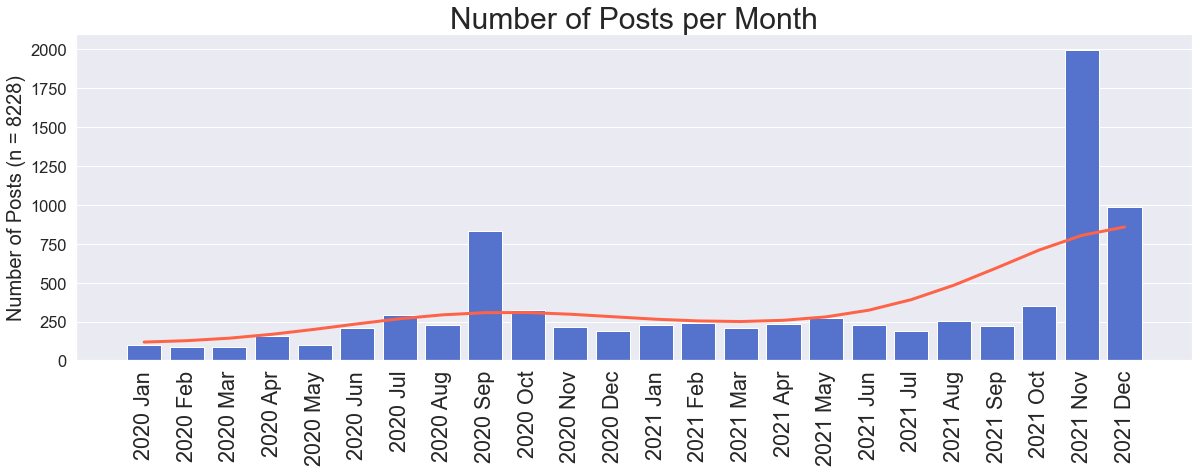

In [34]:
slice = df["shortcode"]
plot_timeseries_histogram(slice, freq="M", aggregate="count", title="Number of Posts per Month",
                          ylabel="Number of Posts (n = {})".format(len(slice)), trendline=True)

%Y %b


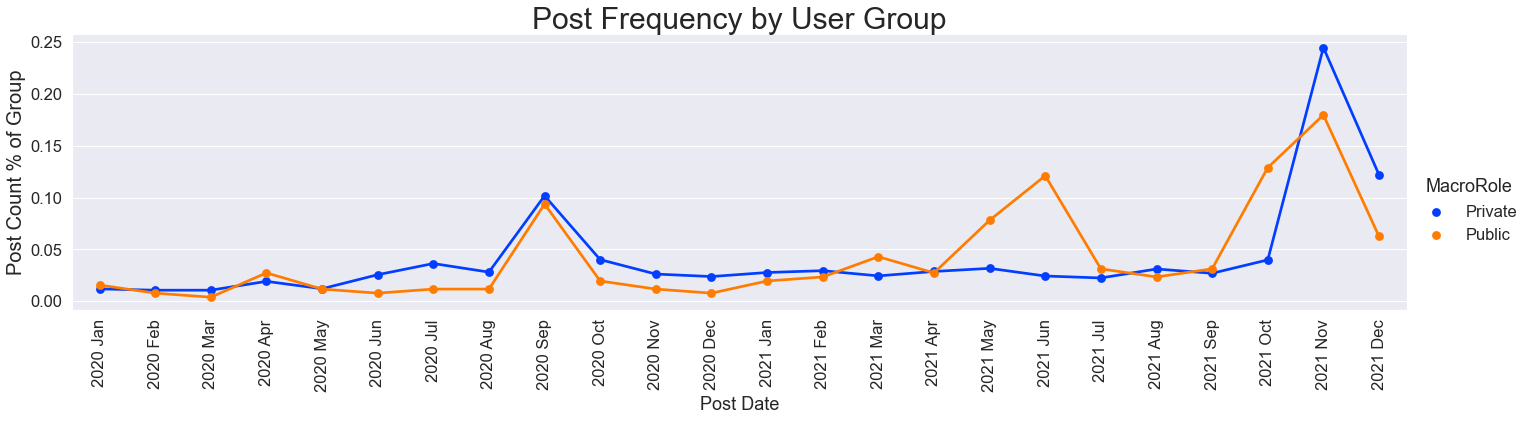

In [35]:
catplot(df[["MacroRole", "shortcode"]], groupby="MacroRole", freq="M", title="Post Frequency by User Group",
        ylabel="Post Count % of Group", relative_to_group=True, id_variable="shortcode")

%Y %b


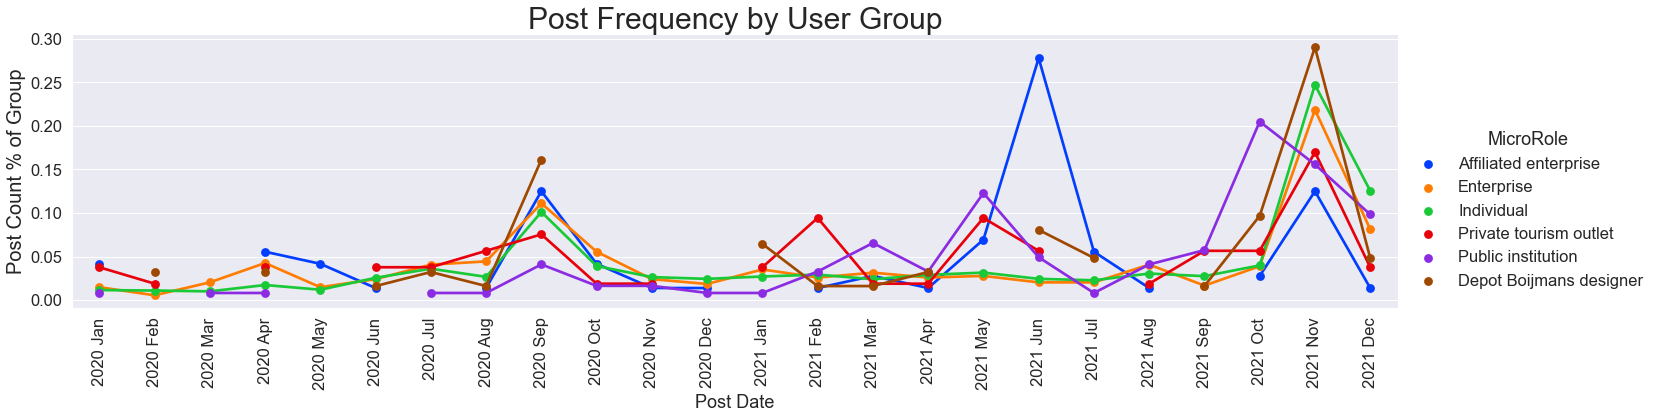

In [36]:
catplot(df[["MicroRole", "shortcode"]], groupby="MicroRole", freq="M", title="Post Frequency by User Group",
        ylabel="Post Count % of Group", relative_to_group=True, id_variable="shortcode")

%b %d


<AxesSubplot:title={'center':'Silver Opening (2020-09-25)'}, ylabel='Number of Posts (n = 1188)'>

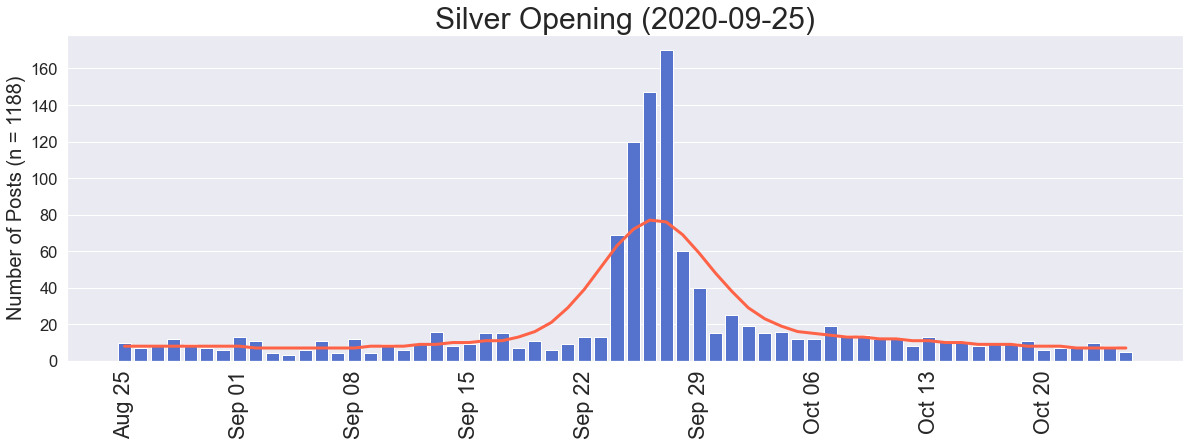

In [37]:
slice = df["2020-08-25":"2020-10-25"]
plot_timeseries_histogram(slice["shortcode"], freq="D", title="Silver Opening (2020-09-25)",
                          ylabel="Number of Posts (n = {})".format(len(slice)), label_every=7, label_string="%b %d",
                          trendline=True)

%b %d


<AxesSubplot:title={'center':'Inauguration (2021-11-06)'}, ylabel='Number of Posts (n = 2567)'>

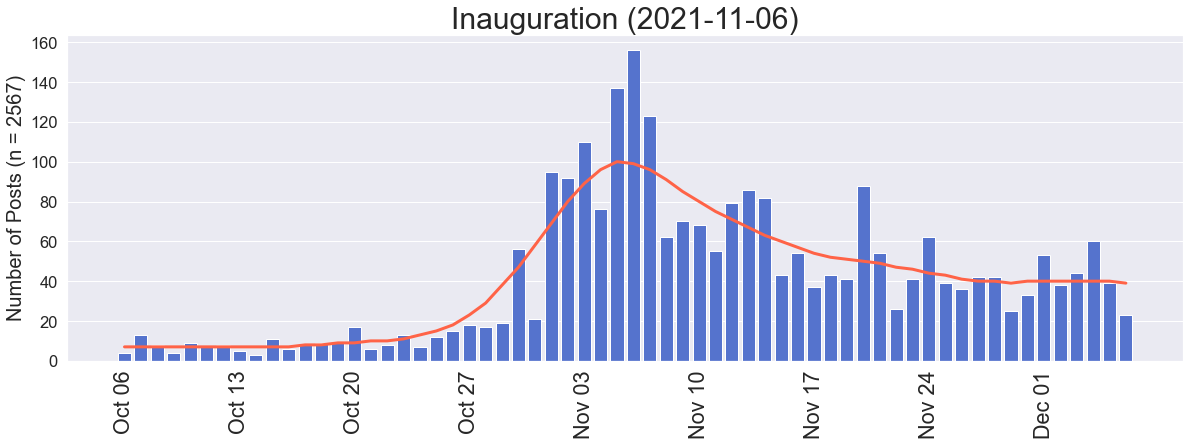

In [38]:
slice = df["2021-10-06":"2021-12-06"]
plot_timeseries_histogram(slice["shortcode"], freq="D", title="Inauguration (2021-11-06)",
                          ylabel="Number of Posts (n = {})".format(len(slice)), label_every=7, label_string="%b %d",
                          trendline=True)